In [1]:
import csv
import pandas as pd
import operator
import xgboost
from xgboost import XGBRegressor # you have to install it first!
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import norm, skew 
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
sample = pd.read_csv(r'all\sample_submission.csv', sep = ',')
sample.head(5)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


# Test file

In [3]:
test = pd.read_csv(r'all\test.csv', sep = ',')
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
# set of columns with at least one NaN value
nan_dict = {}
for col in test:
    nan_count = test[test[col].isna()]
    if len(nan_count) > 0:
        nan_dict[col] = len(nan_count)
        
sorted_nan = sorted(nan_dict.items(), key = operator.itemgetter(1))
sorted_nan.reverse()

In [5]:
# creating a set of columns names (with NaN values in test)
test_li = set()
for i in range(len(sorted_nan)):
    test_li.add(sorted_nan[i][0])

In [6]:
len(test_li)

33

In [7]:
numerical_feature_nan_to_zero = ['BsmtFullBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                                'GarageCars']
string_feature_nan_to_none = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                             'BsmtQual', 'GarageQual', 'GarageCond', 'GarageType', 
                              'MasVnrType']

# test['Functional'] = test['Functional'].fillna('Typ')  
# nella descrizione dice di assumere typical se non specificato

# alley la droppiamo

# per Exterior1st e 2nd lascio il replace della pipeline perche ci deve stare per forza 
# un exterior covering of the house
# test['Fence'] = test['Fence'].fillna('None') DROP
# test['FireplaceQu'] = test['FireplaceQu'].fillna('None') DROP

# Kitchen quality: ci sta per forza una cucina quindi lascio quello della pipeline

# test['LotFrontage'] = test['LotFrontage'].fillna(0)  MEGLIO MEDIAN?


# ms zonning lascio la pipeline

# pool qc e  misc features la droppiamo
# test['SaleType'] = test['SaleType'].fillna('None') MEGLIO MOST FREQUENT
# per utilities lascio la pipeline

**Alley** has 107 null values and the remaining are NaN.  ---> drop ?

**MiscFeature** has 3 second garage, 2 other, 46 shed and the remaining 1408 are missing. We can drop it since we don't need these informations. 

**MiscVal** has 51 different values and the remaining 1408 are missing (*except* miscval = 17000, miscfeature = nan).

**PoolArea** has 1453 zeroes and the remaining 6 are different values. 

**PoolQC** has 2 excellent and 1 good values, the remaining 3 are NaN. The information is not reliable.  ---> drop

# Train

In [8]:
train = pd.read_csv(r'all\train.csv', sep = ',')
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
# set of columns with at least one NaN value
nan_dict_train = {}
for col in train:
    nan_count_train = train[train[col].isna()]
    if len(nan_count_train) > 0:
        nan_dict_train[col] = len(nan_count_train)
        
sorted_nan_train = sorted(nan_dict_train.items(), key = operator.itemgetter(1))
sorted_nan_train.reverse()

## Handling with missing values

### An Extension To Imputation

In [10]:
#dropped_test = test.drop('Id', axis = 1) VIENE FATTO DOPO

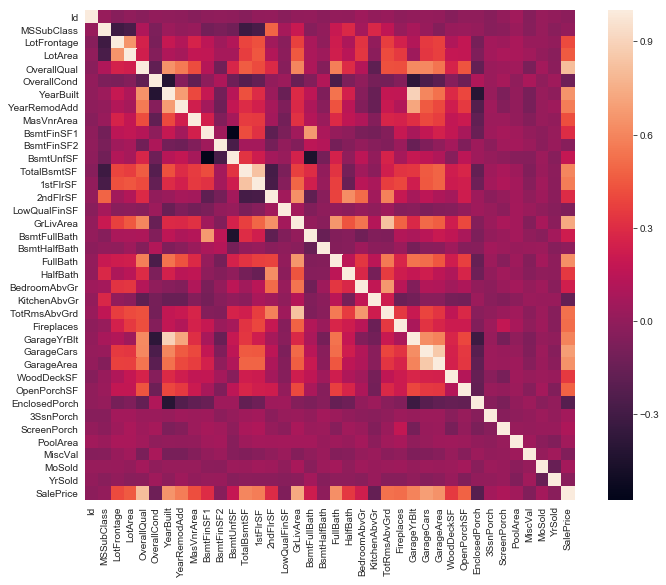

In [11]:
#correlation matrix
corr = train.corr(method = 'spearman')
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corr, vmax = 1, square = True);

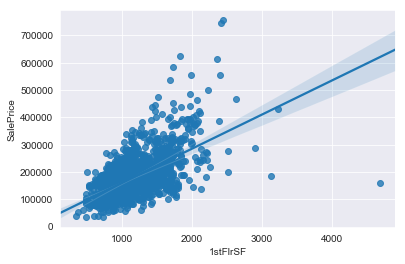

In [12]:
# correlation between a variable and SalePrice
sns.regplot(x = train['1stFlrSF'], y = train['SalePrice'])
plt.show()

In [13]:
# reducing the bias
train.loc[(train.SalePrice < 38000), 'SalePrice'] = train.SalePrice + 15000 

In [14]:
# reducing the bias
train.loc[(train.SalePrice > 620000), 'SalePrice'] = train.SalePrice - 25000

In [15]:
# removing the outlier in LotArea
train = train.drop(train[(train.LotArea > 200000) & (train.SalePrice < 400000)].index)

In [16]:
# removing the outlier in GrLivArea
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 200000)].index)

In [17]:
# removing the outlier in LotFrontage
train = train.drop(train[(train.LotFrontage > 300) & (train.SalePrice < 300000)].index)

In [18]:
# removing outliers from LotArea
train = train.drop(train[train.LotArea > 60000].index)

In [19]:
# removing the outlier in 2ndFlrSF
#train = train.drop(train[(train['2ndFlrSF'] > 2000)].index)

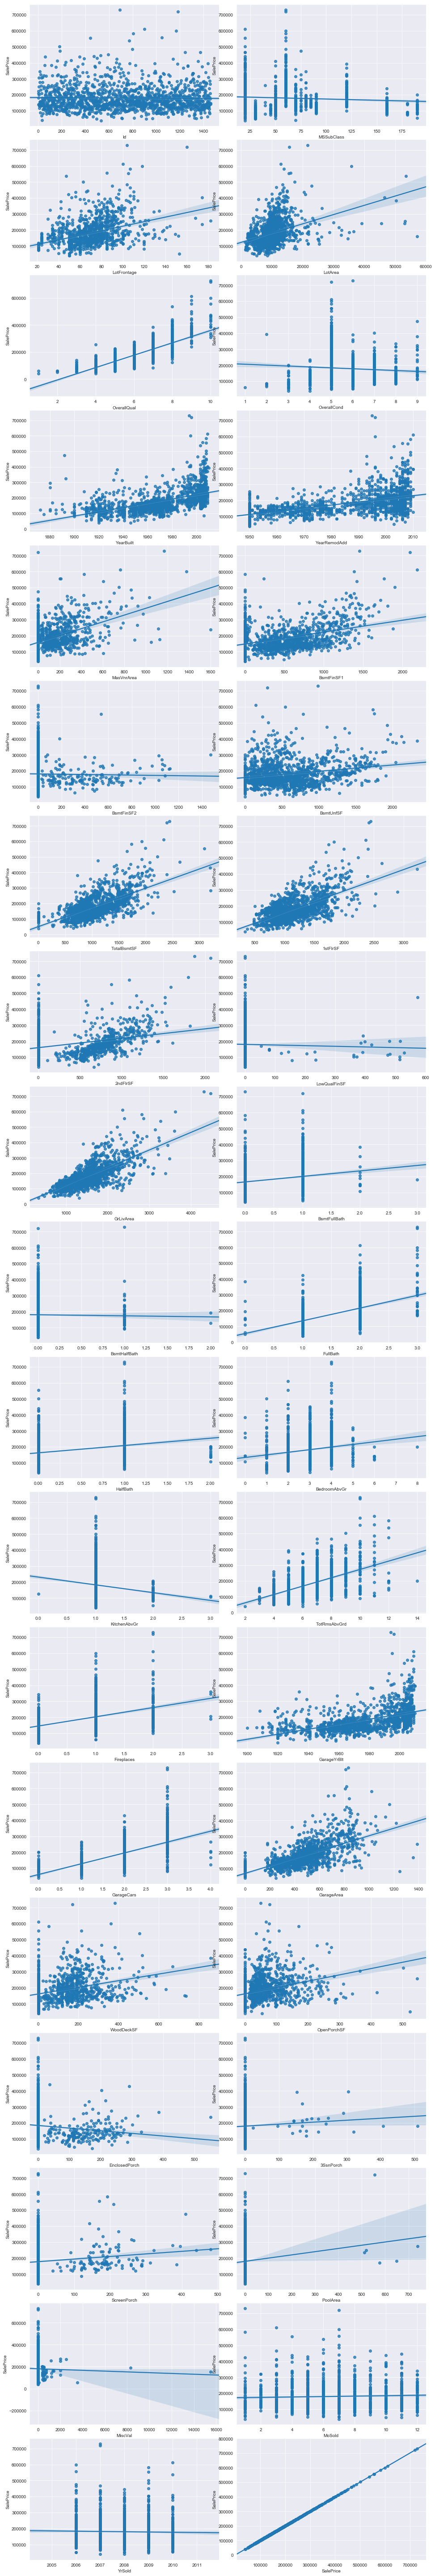

In [20]:
# ignore Id and LotFrontage, we've already removed them
fig, ax = plt.subplots(19, 2, 'row', figsize = (13, 80))
plt.tight_layout()
i = 1
for col in train.columns:
    if train[col].dtype == 'int64' or train[col].dtype == 'float64':
        
        plt.subplot(19, 2, i)
        sns.regplot(x = train[col], y = train['SalePrice'])
        plt.xlabel(col)
        i += 1

In [21]:
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)

In [22]:
# columns to drop
drop_test_col = [tup[0] for tup in sorted_nan[:6]]
# columnt to imputate
imp_test_col = [tup[0] for tup in sorted_nan[6:]]

In [23]:
drop_test_col

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']

In order to remove some columns we can notice that:
* 'TotRmsAbvGrd' and 'GrLivArea' are strongly correlated
* 'TotalBsmtSF' is the sum of BsmtFinSF1, BsmtFinSF2 and BsmtUnfSF

In [24]:
# dropping the columns with have no particular significance
to_drop = ['Id', 'Utilities', 'Condition2', 'TotRmsAbvGrd', 'Functional', 'GarageArea', 
           'TotalBsmtSF', 'WoodDeckSF', 'RoofMatl', 'MasVnrArea', 'GarageFinish'] + drop_test_col

dropped_test = test.drop(to_drop, axis = 1)
dropped_train = train.drop(to_drop, axis = 1)

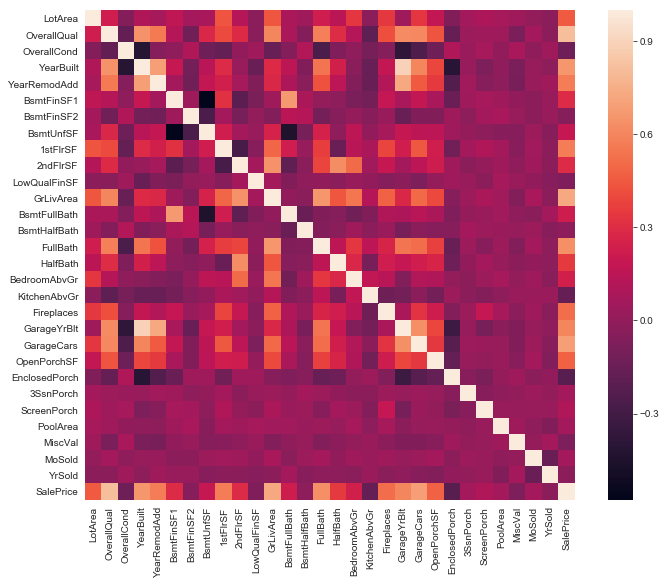

In [25]:
#correlation matrix
corr = dropped_train.corr(method = 'spearman')
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corr, vmax = 1, square = True);

In [26]:
# distinguishing categorical and numeric features
str_feature = [i for i in dropped_test.columns if isinstance(dropped_test[i][0], str)]
num_feature = [i for i in (set(dropped_test.columns).difference(str_feature))]

In [27]:
str_featureSet = set(str_feature)
str_featureSet -= set(string_feature_nan_to_none)

str_feature = list(str_featureSet)

In [28]:
# make copy to avoid changing original data (when Imputing)
new_test = dropped_test.copy()
new_train = dropped_train.copy()
reduced_train = new_train.drop('SalePrice', axis = 1)
final_train_y = np.log1p(train['SalePrice'].astype('float'))

# string conversion from nan to None
str_default_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'None')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

# numeric conversion from nan to constant
num_default_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
    ('scaler', StandardScaler())])

# numeric conversion from nan to median
num_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())])

# string conversion from nan to most_frequent
str_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(
    transformers = [('cat_std', str_default_transformer, string_feature_nan_to_none),
        ('num_std', num_default_transformer, numerical_feature_nan_to_zero),
        ('num', num_transformer, num_feature),
        ('cat', str_transformer, str_feature)])

# Modelling

In [29]:
clf = Pipeline(steps = [('preprocessor', preprocessor),
                          ('classifier', LassoCV(eps = 1e-3, cv = 10))])
train_fit = clf.fit(reduced_train, final_train_y)
predictions1 = clf.predict(new_test) 

print(clf.score(reduced_train, final_train_y))
# 0.9357863963311112

0.9396568725384992


In [30]:
clf = Pipeline(steps = [('preprocessor', preprocessor),
                ('classifier', RidgeCV(cv = 10))])
train_fit = clf.fit(reduced_train, final_train_y)
predictions2 = clf.predict(new_test)

print(clf.score(reduced_train, final_train_y))  
# 0.9402524435539615

0.9412790056215274


In [46]:
clf = Pipeline(steps = [('preprocessor', preprocessor),
                          ('classifier',XGBRegressor(n_estimators = 1000))])
train_fit = clf.fit(reduced_train, final_train_y)
predictions3 = clf.predict(new_test)

print(clf.score(reduced_train, final_train_y)) 

0.9952890399589996


In [41]:
clf = Pipeline(steps = [('preprocessor', preprocessor),
                          ('classifier',ElasticNetCV(cv = 10))])
train_fit = clf.fit(reduced_train, final_train_y)
predictions4 = clf.predict(new_test)

print(clf.score(reduced_train, final_train_y)) 

0.9394785290981365


In [42]:
predictions = (predictions1 + predictions2 + predictions3 + predictions4)/4

In [43]:
pred_sale_price = pd.DataFrame(np.expm1(predictions), 
                               columns = ['SalePrice'], index = None)
pred_sale_price['Id'] = test['Id']
pred_sale_price['SalePrice'] = ((pred_sale_price['SalePrice'] + 250)/ 500).astype(int) * 500

cols = pred_sale_price.columns.tolist()
cols = cols[-1:] + cols[:-1]
pred_sale_price = pred_sale_price[cols]

In [44]:
pred_sale_price.to_csv('predictions.csv', index = False)